In [ ]:
#hide
from medtop.core import *
from medtop.nlp_helpers import *
from medtop.preprocessing import *
from nbdev.showdoc import *
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#hide
# wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# MedTop

> Extracting topics from reflective medical writings

This file will become your README and also the index of your documentation.

## Install

`pip install medtop`

## How to use

Download NLTK data to your machine using `python -m nltk.downloader all`

Import documents from a text file containing a list of all documents

In [ ]:
path_to_file_list = 'data/2019.03.11_DevCorpus/file_list.txt'
my_docs, my_docs_pos, my_docs_loc, raw_sentences, raw_docs = import_docs(path_to_file_list, verbose=False)

You can review the imported documents manually by writing the sentences to disk

In [ ]:
outfile_name = 'output/PREFIX_DocumentSentenceList.txt'
sentences_to_disk(raw_sentences, outfile_name)

Create the TF-IDF matrix. `path_to_corpus_file_list` can be a list of just input files (Local) or a list of all files in the corpus (Global)

In [ ]:
path_to_seed_topics_file_list = 'data/2019.03.12_SEED_TOPICS/FILELIST.txt'
tfidf_dense, dictionary = create_tfidf(path_to_seed_topics_file_list, path_to_corpus_file_list = path_to_file_list, verbose = False)

Get the top phrases for each document.  
**TODO: This currently re-processes each sentence unnecessarily**

In [ ]:
doc_top_phrases = get_doc_top_phrases(raw_docs, dictionary.token2id, tfidf_dense, window_size = 6, include_input_in_tfidf = False)

Create sentence vectors. Multiple options are available:  
**TODO: add explanations**
- TF-IDF
- SVD
- UMAP
- Pre-trained Word2Vec embeddings
- Create Word2Vec embeddings from input corpus

In [ ]:
doc_phrase_vecs = get_doc_word_vectors_tfidf(doc_top_phrases, dictionary, tfidf_dense)
# doc_phrase_vecs = get_doc_word_vectors_svd(doc_top_phrases, dictionary, tfidf_dense)
# doc_phrase_vecs = get_doc_word_vectors_umap(doc_top_phrases, dictionary, tfidf_dense, umap_neighbors = 15, dimensions = 2)
# doc_phrase_vecs = get_doc_word_vectors_pretrained(doc_top_phrases, path_to_w2v_bin_file = "data/pubmed2018_w2v_200D.bin")
# doc_phrase_vecs = get_doc_word_vectors_local(doc_top_phrases, raw_docs, my_docs)

In [ ]:
doc_phrase_vecs = get_doc_word_vectors_local(doc_top_phrases, raw_docs, my_docs)

Filter the sentences, removing any that contain zero "top phrases"  

In [ ]:
total_phrase_num = sum([len(phrase_vecs) for phrase_vecs in doc_phrase_vecs])
just_phrase_vecs, just_phrase_ids, just_phrase_text = filter_sentences(doc_phrase_vecs, doc_top_phrases)

### Clustering

#### K-means Clustering
When using K-means clustering, you can find the optimal k value from a given range. `get_optimal_k` visualizes the silhoute coefficients for a range of k values and returns the value corresponding to the max silhoute coefficient.

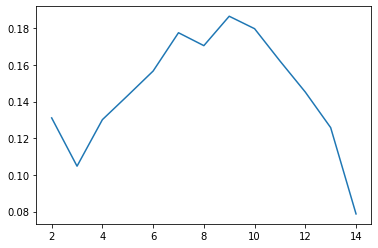

In [ ]:
optimal_k = get_optimal_k(just_phrase_vecs, k_range = range(2, 15), save_chart = False)
cluster_assignments, dist = get_cluster_assignments_kmeans(optimal_k, just_phrase_vecs)

#### Hierarchical Agglomerative Clustering

In [ ]:
i=2
silhouette_score(just_phrase_vecs, [x[0] for x in cut_tree(linkage_matrix, height=i)])
linkage_matrix.shape

ValueError: Number of labels is 17. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:
dist_metric = "euclidean"
if dist_metric == "cosine":
    dist = 1 - cosine_similarity(just_phrase_vecs)
else:
    dist = pairwise_distances(just_phrase_vecs, metric=dist_metric)

linkage_matrix = ward(dist)
h_range = range(1, 15)#100
if dist_metric == "euclidean":
    h_score = [(silhouette_score(just_phrase_vecs, [x[0] for x in cut_tree(linkage_matrix, height=i)] )) for i in h_range]
else:
     h_score = [(silhouette_score(just_phrase_vecs, [x[0] for x in cut_tree(linkage_matrix, height=i)] )) for i in h_range]

fig = plt.plot(h_range, h_score)

ValueError: Number of labels is 17. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, cut_tree
# help(pairwise_distances)

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()